In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import matplotlib as mpl
from scipy.integrate import solve_ivp

In [3]:
# Parameters
n_steps = 1500
dt = 1
ref_price_a, ref_price_b = 100, 100
lambda_a, lambda_b = 1.0, 1.0
std_price_a, std_price_b = 1.0, 1.0
delta_a, delta_b = dt * 0.01, dt * 0.01
phi_a, phi_b = dt * 1, dt * 1
initial_particles_a = 100
initial_particles_b = 100
n_histograms = 1000

# Initialize particles
prices_a = np.random.normal(loc=ref_price_a, scale=std_price_a, size=initial_particles_a)
mask_a = prices_a[:] > ref_price_a + 0.5
prices_a = prices_a[mask_a]
sizes_a = np.random.exponential(scale=1 / lambda_a, size=len(prices_a))
A_initial = prices_a.copy()

prices_b = np.random.normal(loc=ref_price_b, scale=std_price_b, size=initial_particles_b)
mask_b = prices_b[:] < ref_price_b - 0.5
prices_b = prices_b[mask_b]
sizes_b = np.random.exponential(scale=1 / lambda_b, size=len(prices_b))
B_initial = prices_b.copy()

particles_a = np.column_stack((prices_a, sizes_a))
particles_b = np.column_stack((prices_b, sizes_b))

starting_distribution_a = particles_a.copy()
starting_distribution_b = particles_b.copy()

price_bins = np.linspace(
    min(ref_price_a, ref_price_b) - 5 * std_price_b,
    max(ref_price_a, ref_price_b) + 5 * std_price_a,
    100
)

hist_a, _ = np.histogram(A_initial, bins=price_bins)
hist_b, _ = np.histogram(B_initial, bins=price_bins)

# Arrays to store statistics
time_steps = []
n_a_array = []
n_b_array = []
mean_price_a_array = []
mean_price_b_array = []
std_price_a_array = []
std_price_b_array = []

# To store histograms of the last 1000 steps
last_histograms_a = []
last_histograms_b = []

# Functions
def add_entries():
    global particles_a, particles_b

    n_new_a = np.random.poisson(phi_a)
    n_new_b = np.random.poisson(phi_b)

    # Generate all new A and B particles
    new_prices_a = np.random.normal(loc=ref_price_a, scale=std_price_a, size=n_new_a)
    new_sizes_a = np.random.exponential(scale=1 / lambda_a, size=n_new_a)
    
    new_prices_b = np.random.normal(loc=ref_price_b, scale=std_price_b, size=n_new_b)
    new_sizes_b = np.random.exponential(scale=1 / lambda_b, size=n_new_b)

    # Create a list of all new particles with their type info
    all_new_particles = []
    
    for p, s in zip(new_prices_a, new_sizes_a):
        all_new_particles.append(('A', p, s))
        
    for p, s in zip(new_prices_b, new_sizes_b):
        all_new_particles.append(('B', p, s))

    # Shuffle to randomize processing order
    np.random.shuffle(all_new_particles)

    # Process each particle in the shuffled list
    for particle in all_new_particles:
        ptype, price, size = particle
        
        if ptype == 'A':
            # Try to insert A particle: must be <= max price in B
            if len(particles_b) == 0:
                # No B particles available to remove; skip adding
                continue
                
            max_price_idx = np.argmax(particles_b[:, 0])
            price_b, size_b = particles_b[max_price_idx]
            
            if price <= price_b:
                particles_b = np.delete(particles_b, max_price_idx, axis=0)
            else:
                particles_a = np.vstack((particles_a, [price, size]))
                
        elif ptype == 'B':
            # Try to insert B particle: must be >= min price in A
            if len(particles_a) == 0:
                # No A particles available to remove; skip adding
                continue
                
            min_price_idx = np.argmin(particles_a[:, 0])
            price_a, size_a = particles_a[min_price_idx]
            
            if price_a <= price:
                particles_a = np.delete(particles_a, min_price_idx, axis=0)
            else:
                particles_b = np.vstack((particles_b, [price, size]))
    
def apply_cancellations():
    global particles_a, particles_b

    particles_a = particles_a[np.random.rand(len(particles_a)) > delta_a]
    particles_b = particles_b[np.random.rand(len(particles_b)) > delta_b]

def record_statistics(step):
    global time_steps, n_a_array, n_b_array, mean_price_a_array, mean_price_b_array, std_price_a_array, std_price_b_array, particles_a, particles_b

    time_steps.append(step)
    n_a_array.append(len(particles_a))
    n_b_array.append(len(particles_b))

def record_histograms(n_histograms = n_histograms):
    global last_histograms_a, last_histograms_b
    
    hist_a, _ = np.histogram(particles_a[:, 0], bins=price_bins)
    hist_b, _ = np.histogram(particles_b[:, 0], bins=price_bins)
    
    last_histograms_a.append(hist_a)
    last_histograms_b.append(hist_b)

    if len(last_histograms_a) > n_histograms:
        last_histograms_a.pop(0)
    if len(last_histograms_b) > n_histograms:
        last_histograms_b.pop(0)

def one_step(step):
    record_statistics(step)
    add_entries()
    apply_cancellations()
    if step >= n_steps - n_histograms:
        record_histograms()

# Run simulation
for step in range(n_steps):
    one_step(step)
    if len(particles_a) == 0 and len(particles_b) == 0:
        print(f"Simulation ended at step {step}.")
        break

# Average histograms
dp = price_bins[1]-price_bins[0]
final_counts_a = np.mean(last_histograms_a/dp, axis=0)
final_counts_b = np.mean(last_histograms_b/dp, axis=0)

initial_counts_a, _ = np.histogram(starting_distribution_a[:, 0], bins=price_bins)
initial_counts_b, _ = np.histogram(starting_distribution_b[:, 0], bins=price_bins)
xvalues = [(price_bins[i] + price_bins[i+1])/2 for i in range(len(price_bins) -1 )]

In [5]:
with open("resources\\Temperatura efectiva\\dist_eq_n_a_1.pkl", 'rb') as f:
    n_a_est_sim_1 = pickle.load(f)
with open("resources\\Temperatura efectiva\\dist_eq_n_b_1.pkl", 'rb') as f:
    n_b_est_sim_1 = pickle.load(f)

with open("resources\\Temperatura efectiva\\N_a_1.pkl", 'rb') as f:
    n_a_sim_1 = pickle.load(f)
with open("resources\\Temperatura efectiva\\N_b_1.pkl", 'rb') as f:
    n_b_sim_1 = pickle.load(f)
with open("resources\\Temperatura efectiva\\times_1.pkl", 'rb') as f:
    times_sim = pickle.load(f)

with open("resources\\Temperatura efectiva\\dist_eq_n_a_2.pkl", 'rb') as f:
    n_a_est_sim_2 = pickle.load(f)
with open("resources\\Temperatura efectiva\\dist_eq_n_b_2.pkl", 'rb') as f:
    n_b_est_sim_2 = pickle.load(f)

with open("resources\\Temperatura efectiva\\N_a_2.pkl", 'rb') as f:
    n_a_sim_2 = pickle.load(f)
with open("resources\\Temperatura efectiva\\N_b_2.pkl", 'rb') as f:
    n_b_sim_2 = pickle.load(f)

with open("resources\\Temperatura efectiva\\dist_eq_n_a_3.pkl", 'rb') as f:
    n_a_est_sim_3 = pickle.load(f)
with open("resources\\Temperatura efectiva\\dist_eq_n_b_3.pkl", 'rb') as f:
    n_b_est_sim_3 = pickle.load(f)

with open("resources\\Temperatura efectiva\\N_a_3.pkl", 'rb') as f:
    n_a_sim_3 = pickle.load(f)
with open("resources\\Temperatura efectiva\\N_b_3.pkl", 'rb') as f:
    n_b_sim_3 = pickle.load(f)

with open("resources\\Temperatura efectiva\\dist_eq_n_a_4.pkl", 'rb') as f:
    n_a_est_sim_4 = pickle.load(f)
with open("resources\\Temperatura efectiva\\dist_eq_n_b_4.pkl", 'rb') as f:
    n_b_est_sim_4 = pickle.load(f)

with open("resources\\Temperatura efectiva\\N_a_4.pkl", 'rb') as f:
    n_a_sim_4 = pickle.load(f)
with open("resources\\Temperatura efectiva\\N_b_4.pkl", 'rb') as f:
    n_b_sim_4 = pickle.load(f)

with open("resources\\Temperatura efectiva\\dist_eq_n_a_5.pkl", 'rb') as f:
    n_a_est_sim_5 = pickle.load(f)
with open("resources\\Temperatura efectiva\\dist_eq_n_b_5.pkl", 'rb') as f:
    n_b_est_sim_5 = pickle.load(f)

with open("resources\\Temperatura efectiva\\N_a_5.pkl", 'rb') as f:
    n_a_sim_5 = pickle.load(f)
with open("resources\\Temperatura efectiva\\N_b_5.pkl", 'rb') as f:
    n_b_sim_5 = pickle.load(f)

with open("resources\\Temperatura efectiva\\dist_eq_n_a_6.pkl", 'rb') as f:
    n_a_est_sim_6 = pickle.load(f)
with open("resources\\Temperatura efectiva\\dist_eq_n_b_6.pkl", 'rb') as f:
    n_b_est_sim_6 = pickle.load(f)

with open("resources\\Temperatura efectiva\\N_a_6.pkl", 'rb') as f:
    n_a_sim_6 = pickle.load(f)
with open("resources\\Temperatura efectiva\\N_b_6.pkl", 'rb') as f:
    n_b_sim_6 = pickle.load(f)

with open("resources\\Temperatura efectiva\\dist_eq_n_a_7.pkl", 'rb') as f:
    n_a_est_sim_7 = pickle.load(f)
with open("resources\\Temperatura efectiva\\dist_eq_n_b_7.pkl", 'rb') as f:
    n_b_est_sim_7 = pickle.load(f)

with open("resources\\Temperatura efectiva\\N_a_7.pkl", 'rb') as f:
    n_a_sim_7 = pickle.load(f)
with open("resources\\Temperatura efectiva\\N_b_7.pkl", 'rb') as f:
    n_b_sim_7 = pickle.load(f)

with open("resources\\Temperatura efectiva\\dist_eq_n_a_8.pkl", 'rb') as f:
    n_a_est_sim_8 = pickle.load(f)
with open("resources\\Temperatura efectiva\\dist_eq_n_b_8.pkl", 'rb') as f:
    n_b_est_sim_8 = pickle.load(f)

with open("resources\\Temperatura efectiva\\N_a_8.pkl", 'rb') as f:
    n_a_sim_8 = pickle.load(f)
with open("resources\\Temperatura efectiva\\N_b_8.pkl", 'rb') as f:
    n_b_sim_8 = pickle.load(f)

with open("resources\\Temperatura efectiva\\dist_eq_n_a_9.pkl", 'rb') as f:
    n_a_est_sim_9 = pickle.load(f)
with open("resources\\Temperatura efectiva\\dist_eq_n_b_9.pkl", 'rb') as f:
    n_b_est_sim_9 = pickle.load(f)

with open("resources\\Temperatura efectiva\\N_a_9.pkl", 'rb') as f:
    n_a_sim_9 = pickle.load(f)
with open("resources\\Temperatura efectiva\\N_b_9.pkl", 'rb') as f:
    n_b_sim_9 = pickle.load(f)

with open("resources\\Temperatura efectiva\\dist_eq_n_a_10.pkl", 'rb') as f:
    n_a_est_sim_10 = pickle.load(f)
with open("resources\\Temperatura efectiva\\dist_eq_n_b_10.pkl", 'rb') as f:
    n_b_est_sim_10 = pickle.load(f)

with open("resources\\Temperatura efectiva\\N_a_10.pkl", 'rb') as f:
    n_a_sim_10 = pickle.load(f)
with open("resources\\Temperatura efectiva\\N_b_10.pkl", 'rb') as f:
    n_b_sim_10 = pickle.load(f)

n_a_sim = np.mean(np.array([n_a_sim_1, n_a_sim_2, n_a_sim_3, n_a_sim_4, n_a_sim_5, n_a_sim_6, n_a_sim_7, n_a_sim_8, n_a_sim_9, n_a_sim_10]),axis=0)
n_b_sim = np.mean(np.array([n_b_sim_1,n_b_sim_2, n_b_sim_3, n_b_sim_4, n_a_sim_5, n_a_sim_6, n_a_sim_7, n_a_sim_8, n_a_sim_9, n_a_sim_10]), axis=0)
n_a_est_sim = np.mean(np.array([n_a_est_sim_1,n_a_est_sim_2,n_a_est_sim_3,n_a_est_sim_4,n_a_est_sim_5, n_a_est_sim_6, n_a_est_sim_7, n_a_est_sim_8, n_a_est_sim_9, n_a_est_sim_10]), axis=0)
n_b_est_sim = np.mean(np.array([n_b_est_sim_1,n_b_est_sim_2,n_b_est_sim_3, n_b_est_sim_4, n_b_est_sim_5, n_b_est_sim_6, n_b_est_sim_7, n_b_est_sim_8, n_b_est_sim_9, n_b_est_sim_10]), axis=0)

In [ ]:
# Price grid
ref_price_a = ref_price_b = 100
std_price_a = std_price_b = 1

price_bins = np.linspace(
    min(ref_price_a, ref_price_b) - 5 * std_price_b,
    max(ref_price_a, ref_price_b) + 5 * std_price_a,
    500
)

# Midpoints of bins and bin width
midpoints = (price_bins[:-1] + price_bins[1:]) / 2
dp = midpoints[1] - midpoints[0]
N = len(midpoints)  # Number of bins

p_scaled = midpoints - ref_price_a

# Parameters
phi_a = phi_b = 1
Delta_a = Delta_b = 0.01
kappa_a = kappa_b = 0.7
gamma_a = gamma_b = 0
mu_a = mu_b = 100
sigma_a = sigma_b = 1
beta = 3

weighted_prices = np.array(beta * p_scaled)
max_exp_arg = 700  
exp_weighted_prices = np.exp(np.clip(weighted_prices, -max_exp_arg, max_exp_arg))
exp_weighted_prices_neg = np.exp(np.clip(-weighted_prices, -max_exp_arg, max_exp_arg))

# Precompute source terms
P_a_vals = (1 / (sigma_a * np.sqrt(2 * np.pi))) * np.exp(- (midpoints - mu_a)**2 / (2 * sigma_a**2))
source_a = phi_a * P_a_vals
source_b = phi_b * P_a_vals  

# Initial conditions
samples_a = A_initial.copy()
samples_b = B_initial.copy()

hist_a, _ = np.histogram(samples_a, bins=price_bins) 
hist_b, _ = np.histogram(samples_b, bins=price_bins) 

# Add a small epsilon 
epsilon = 1e1
hist_a = np.array(hist_a, dtype=np.float64) / dp
hist_b = np.array(hist_b, dtype=np.float64) / dp
hist_a += epsilon
hist_b += epsilon

# Initial state vector
state0 = np.concatenate((hist_a, hist_b))

# Define the derivative function
def derivs(t, state):
    n_a = state[:N]
    n_b = state[N:]

    # Reverse cumulative sum for integral from p to infinity (n_b)
    weighted_n_b = exp_weighted_prices * n_b
    cumsum_b_rev = np.cumsum(weighted_n_b[::-1])[::-1]
    integral_b = cumsum_b_rev * dp

    # Forward cumulative sum for integral from 0 to p (n_a)
    weighted_n_a = exp_weighted_prices_neg * n_a
    cumsum_a_forward = np.cumsum(weighted_n_a)
    integral_a = cumsum_a_forward * dp

    # Compute derivatives
    dna_dt = source_a - kappa_a * (1 - gamma_a) * exp_weighted_prices_neg * n_a * integral_b - Delta_a * n_a
    dnb_dt = source_b - kappa_b * (1 - gamma_b) * exp_weighted_prices * n_b * integral_a - Delta_b * n_b

    return np.concatenate((dna_dt, dnb_dt))

# Time parameters
T = 1500
dt = 0.1
t_eval = np.arange(0, T + dt, dt)

# Solve the ODE system
sol = solve_ivp(derivs, (0, T), state0, t_eval=t_eval, method='Radau')

# Extract and compute total N_a and N_b over time
N_a_total = np.sum(sol.y[:N, :], axis=0) * dp
N_b_total = np.sum(sol.y[N:, :], axis=0) * dp

In [8]:
num_sims= 10

std_mean_series_a = np.std(n_a_sim, axis=0) / np.sqrt(num_sims)

upper_bound_mean_series_a = n_a_sim + std_mean_series_a
lower_bound_mean_series_a = n_a_sim - std_mean_series_a

std_mean_series_b = np.std(n_b_sim, axis=0) / np.sqrt(num_sims)

upper_bound_mean_series_b = n_b_sim + std_mean_series_b
lower_bound_mean_series_b = n_b_sim - std_mean_series_b

In [ ]:
price_bins_sim = np.linspace(
    min(ref_price_a, ref_price_b) - 5 * std_price_b,
    max(ref_price_a, ref_price_b) + 5 * std_price_a,
    100
)

# Midpoints and bin width
midpoints_sim = (price_bins_sim[:-1] + price_bins_sim[1:]) / 2
dp_sim = midpoints_sim[1] - midpoints_sim[0]

n_a_last = sol.y[:N, -1:]
n_b_last = sol.y[N:, -1:]

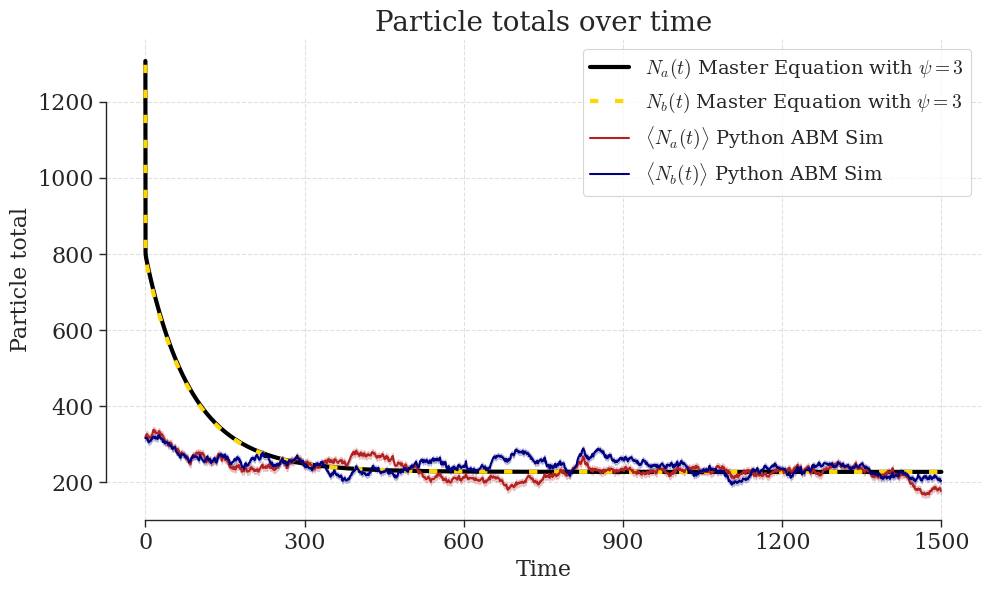

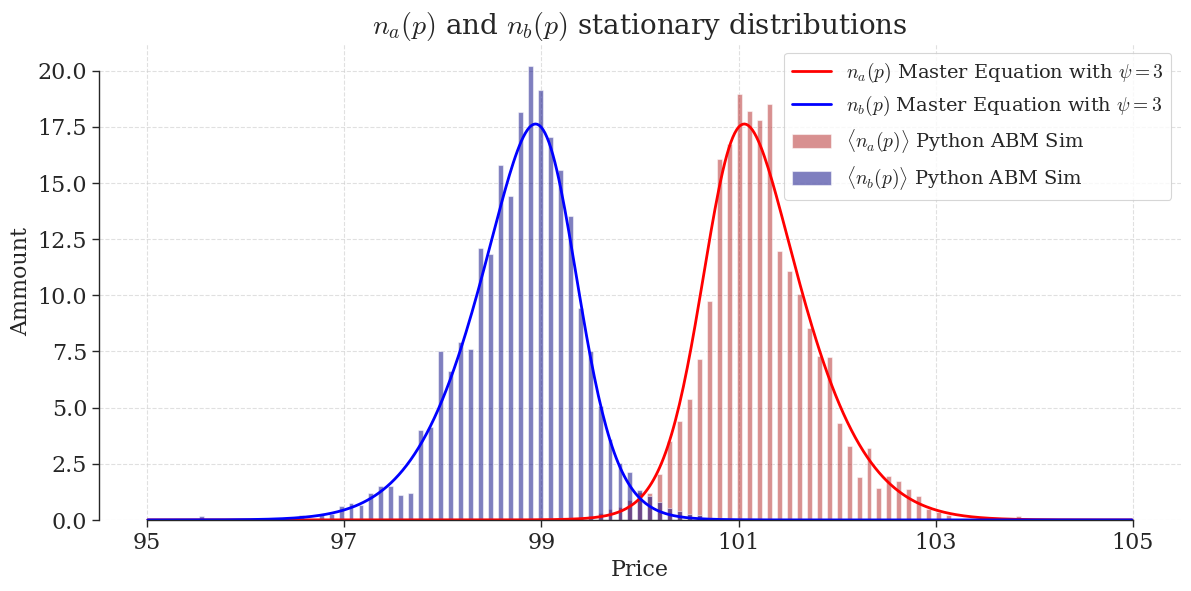

In [ ]:
# Set Seaborn style and font settings
sns.set(style="ticks", context="paper")
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'cm' 
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['lines.linewidth'] = 2

plt.figure(figsize=(10, 6))

# Master equation solutions
plt.plot(sol.t, N_a_total / dp_sim, label=r'$N_a(t)$ Master Equation with $\psi = 3$', 
         color='black', linestyle='-', linewidth=3)
plt.plot(sol.t, N_b_total / dp_sim, label=r'$N_b(t)$ Master Equation with $\psi = 3$', 
         color='gold', linestyle=(0, (2, 4)), linewidth=3)

# Simulation results
plt.plot(time_steps, n_a_sim / dp_sim, label=r'$\langle N_a(t) \rangle$ Python ABM Sim', 
         color='firebrick', linewidth=1.5, linestyle='-')
plt.fill_between(times_sim, lower_bound_mean_series_a / dp_sim, upper_bound_mean_series_a / dp_sim,
                 color='firebrick', alpha=0.2)

plt.plot(time_steps, n_b_sim / dp_sim, label=r'$\langle N_b(t) \rangle$ Python ABM Sim',
         color='navy', linewidth=1.5, linestyle='-')
plt.fill_between(times_sim, lower_bound_mean_series_b / dp_sim, upper_bound_mean_series_b / dp_sim,
                 color='navy', alpha=0.2)

plt.title('Particle totals over time', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.xticks(np.arange(0, 1501, step=300))
plt.ylabel('Particle total', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='best', frameon=True, fancybox=True)
sns.despine(trim=True)
plt.tight_layout()
plt.savefig("images/Conexion/totales con beta 3 y phi 0.1 ingles.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))

# Master equation lines
plt.plot(midpoints, n_a_last, label=r'$n_a(p)$ Master Equation with $\psi = 3$', 
         color='red', linestyle='-', linewidth=2)
plt.plot(midpoints, n_b_last, label=r'$n_b(p)$ Master Equation with $\psi = 3$', 
         color='blue', linestyle='-', linewidth=2)

# Simulation histograms 
bar_width = 0.05
plt.bar(xvalues, n_a_est_sim, width=bar_width, align='center',
        alpha=0.5, label=r'$\langle n_a(p) \rangle$ Python ABM Sim', color='firebrick')
plt.bar(xvalues, n_b_est_sim, width=bar_width, align='center',
        alpha=0.5, label=r'$\langle n_b(p) \rangle$ Python ABM Sim', color='navy')

plt.title(r'$n_a(p)$ and $n_b(p)$ stationary distributions', fontsize=20)
plt.xlabel('Price', fontsize=16)
plt.xticks(np.arange(95, 106, step=2))
plt.ylabel('Ammount', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right', frameon=True, fancybox=True)
sns.despine(trim=True)
plt.tight_layout()
plt.savefig("images/Conexion/perfiles estacionarios con beta 3 y phi 0.1 ingles.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()